In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import h5py
from scipy.ndimage.filters import gaussian_filter
from time import time

import py4DSTEM
from py4DSTEM.process.dpc import get_wavenumber

In [2]:
# Load data

fp = "/home/ben/Data/20190509_DPC_MoS2_binned_HamishBrown/MoS2_binned.h5"
f = h5py.File(fp,'r')
data = np.array(f['4D-STEM_data/datacube/datacube'])
f.close()

dc = py4DSTEM.file.datastructure.DataCube(data[:,:255,:,:])

In [3]:
dc.data4D.shape

(256, 255, 63, 64)

### Display data

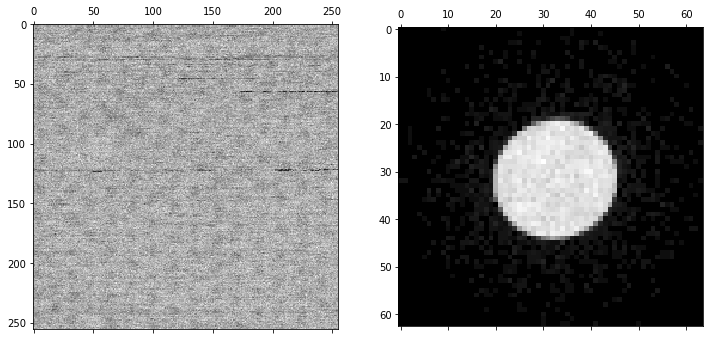

In [4]:
rx,ry = 30,30
power = .5

BF = np.average(dc.data4D,axis=(2,3))
DP = dc.data4D[rx,ry,:,:]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(BF)
ax2.matshow(DP**power)
plt.show()

### DPC

In [7]:
rsize = [40,40]
keV = 60
alpha = 30.6*1e-3
kalpha = get_wavenumber(keV*1e3)*alpha

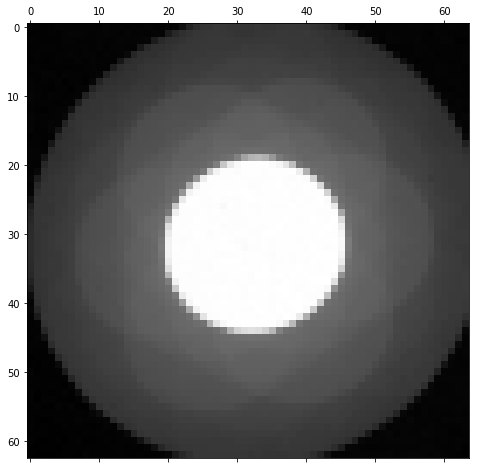

In [8]:
# Get PACBED

power = 0.1

PACBED = np.average(dc.data4D,axis=(0,1))

# Show
fig,ax = plt.subplots(figsize=(8,8,))
ax.matshow(PACBED**power)
plt.show()

## Hamish's GIU

The function call is:
    
```
origin, size, rotation, flip = Diffraction_sizing_and_rotation(PACBED,datacube)
```

We want to get all of these pieces!

The procedure in his approach is, I believe:

1. Get the CBED center and radius
2. Calculate reconstruction, assuming no rotational offset
3. Get rotational offset (+flip), by recalculating reconstruction with varying offsets

### 1. Get CBED center and radius

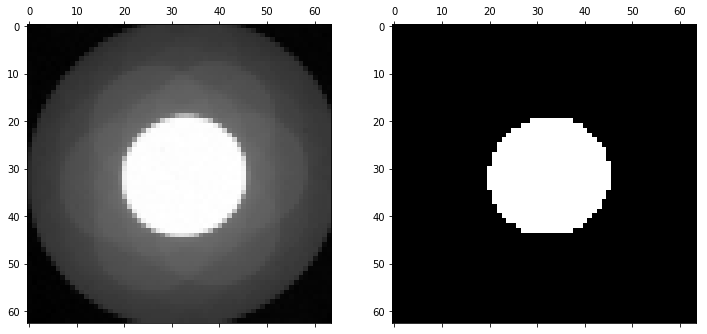

In [9]:
thresh = .5
power=0.1

mask = PACBED > np.max(PACBED)*thresh

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(PACBED**power)
ax2.matshow(mask)
plt.show()

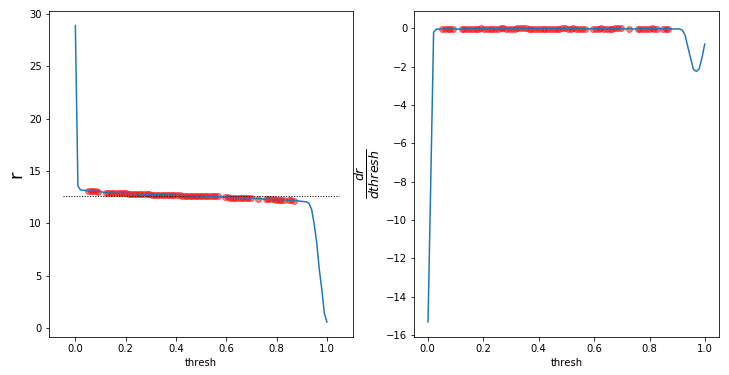

r = 12.624


In [11]:
# Get bright field disk radius

N = 100
thresh_lower = 0.001
thresh_upper = 0.999

thresh_vals = np.linspace(thresh_lower,thresh_upper,N)
r_vals = np.zeros(N)

for i in range(len(thresh_vals)):
    thresh = thresh_vals[i]
    mask = PACBED > np.max(PACBED)*thresh
    r_vals[i] = np.sqrt(np.sum(mask)/np.pi)

dr_dtheta = np.gradient(r_vals)
mask = (dr_dtheta <= 0) * (dr_dtheta >= 2*np.median(dr_dtheta)) 

r = np.average(r_vals[mask])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(thresh_vals,r_vals)
ax2.plot(thresh_vals,dr_dtheta)
ax1.scatter(thresh_vals[mask],r_vals[mask],color='r',alpha=0.5)
ax2.scatter(thresh_vals[mask],dr_dtheta[mask],color='r',alpha=0.5)
ax1.hlines(r,ax1.get_xlim()[0],ax1.get_xlim()[1],linestyle=':',linewidth=1)
ax1.set_xlabel('thresh')
ax1.set_ylabel('r',size=18)
ax2.set_xlabel('thresh')
ax2.set_ylabel(r'$\frac{dr}{dthresh}$',size=18)
plt.show()

print("r = {:.5}".format(r))

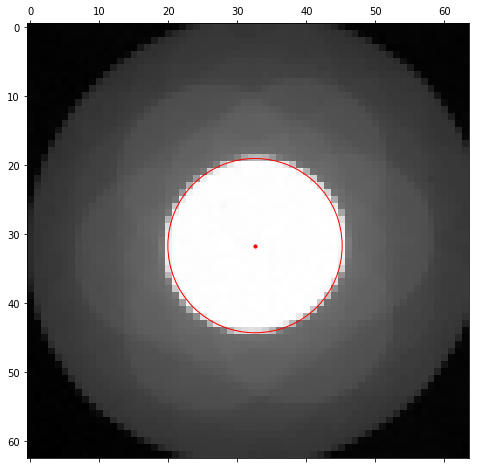

In [12]:
# Get the bright field disk center, and plot

sigma = 10
x0,y0 = py4DSTEM.process.utils.get_CoM(PACBED)

# Show
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(PACBED**power)
ax.scatter(y0,x0,color='r',s=10)
circle = Circle((y0,x0),r,fill=False,edgecolor='r',linewidth=1)
ax.add_patch(circle)
plt.show()

### 2. Get reconstruction

#### Get CoM

In [14]:
# Get coordinates

qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
qx = qx - x0
qy = qy - y0
qr = np.hypot(qx,qy)

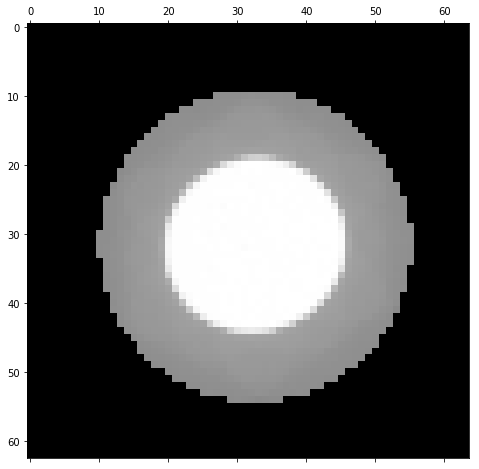

In [17]:
# Optionally, get mask

usemask = True
expand = 10

if usemask:
    mask = qr < r + expand
    qx = mask*qx
    qy = mask*qy
else:
    mask = True

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((mask*PACBED)**power)
plt.show()

In [22]:
# Get CoM shifts

normalize_shifts = True
flip = True

t0 = time()
CoMx = np.zeros((dc.R_Nx,dc.R_Ny))
CoMy = np.zeros((dc.R_Nx,dc.R_Ny))
mass = np.zeros((dc.R_Nx,dc.R_Ny))

for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        DP = dc.data4D[Rx,Ry,:,:]
        mass[Rx,Ry] = np.sum(DP*mask)
        CoMx[Rx,Ry] = np.sum(qx*DP) / mass[Rx,Ry]
        CoMy[Rx,Ry] = np.sum(qy*DP) / mass[Rx,Ry]

if normalize_shifts:
    CoMx -= np.mean(CoMx)
    CoMy -= np.mean(CoMy)
    
if flip:
    CoMx = -CoMx

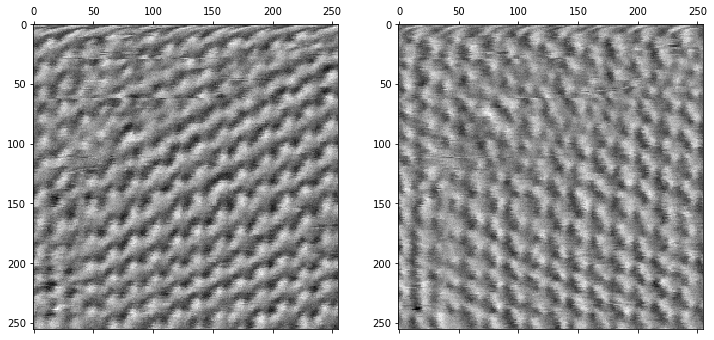

In [23]:
# Show

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(CoMx)
ax2.matshow(CoMy)
plt.show()

#### Get phase from CoM

In [24]:
# Perform reconstruction

n_iter = 1
pad = 1

# Pad arrays
CoMx_pad = np.pad(np.copy(CoMx),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
CoMy_pad = np.pad(np.copy(CoMy),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
mask_pad = np.pad(np.ones_like(CoMx),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')==1
R_Nx_pad,R_Ny_pad = mask_pad.shape

# Operators for solving the differential equation in Fourier space
# See, e.g., Close et al, Ultramic 159 (2015) 124-137 or Ishizuka, Microscopy (2017) 397-405
kx,ky = py4DSTEM.process.utils.make_Fourier_coords2D(R_Nx_pad,R_Ny_pad,pixelSize=1)
kr2 = (kx**2+ky**2)
denominator = 1j*kr2
mask_divbyzero = np.abs(denominator) > 1e-16

# Reconstruction
phase = np.zeros((R_Nx_pad,R_Ny_pad))
qphase = np.zeros((R_Nx_pad,R_Ny_pad),dtype=complex)
for i in range(n_iter):
    # Take Fourier transform of CoM components
    fftIx = np.fft.fft2(np.asarray(CoMx_pad,dtype=complex))
    fftIy = np.fft.fft2(np.asarray(CoMy_pad,dtype=complex))
    
    # Again, see Close et al or Ishizuka et al
    numerator = (kx*fftIx + ky*fftIy)
    
    # Calculate phase solution
    qphase[mask_divbyzero] = numerator[mask_divbyzero] / denominator[mask_divbyzero]
    
    # Return real part of inverse Fourier transform of phase
    phase += np.real(np.fft.fft2(qphase))
    
    # Iteratively: find difference between CoM predicted from current solution of potential and measured CoM
    CoMx_pad = np.pad(np.copy(CoMx),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    CoMy_pad = np.pad(np.copy(CoMy),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    CoMx_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)
    CoMy_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)

phase = phase[dc.R_Nx*pad:dc.R_Nx*(pad+1),dc.R_Ny*pad:dc.R_Ny*(pad+1)]

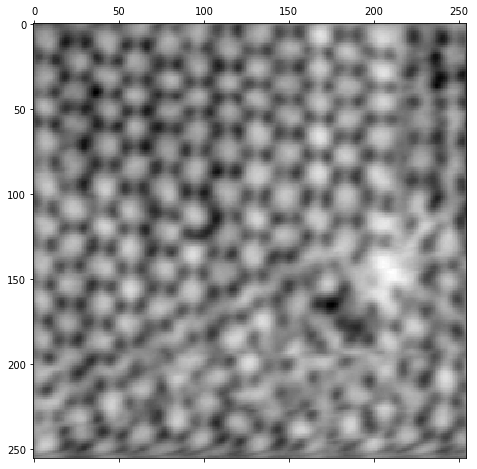

In [25]:
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(phase)
plt.show()

#### 3. Get rotation and flip

In [26]:
angle = 30

CoMx_rot,CoMy_rot = py4DSTEM.process.dpc.rotate_point((0,0), [CoMx,CoMy], np.radians(angle))

In [27]:
# Perform reconstruction

n_iter = 1
pad = 1

# Pad arrays
CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
mask_pad = np.pad(np.ones_like(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')==1
R_Nx_pad,R_Ny_pad = mask_pad.shape

# Operators for solving the differential equation in Fourier space
# See, e.g., Close et al, Ultramic 159 (2015) 124-137 or Ishizuka, Microscopy (2017) 397-405
kx,ky = py4DSTEM.process.utils.make_Fourier_coords2D(R_Nx_pad,R_Ny_pad,pixelSize=1)
kr2 = (kx**2+ky**2)
denominator = 1j*kr2
mask_divbyzero = np.abs(denominator) > 1e-16

# Reconstruction
phase = np.zeros((R_Nx_pad,R_Ny_pad))
qphase = np.zeros((R_Nx_pad,R_Ny_pad),dtype=complex)
for i in range(n_iter):
    # Take Fourier transform of CoM components
    fftIx = np.fft.fft2(np.asarray(CoMx_pad,dtype=complex))
    fftIy = np.fft.fft2(np.asarray(CoMy_pad,dtype=complex))
    
    # Again, see Close et al or Ishizuka et al
    numerator = (kx*fftIx + ky*fftIy)
    
    # Calculate phase solution
    qphase[mask_divbyzero] = numerator[mask_divbyzero] / denominator[mask_divbyzero]
    
    # Return real part of inverse Fourier transform of phase
    phase += np.real(np.fft.fft2(qphase))
    
    # Iteratively: find difference between CoM predicted from current solution of potential and measured CoM
    CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    CoMx_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)
    CoMy_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)

phase = phase[dc.R_Nx*pad:dc.R_Nx*(pad+1),dc.R_Ny*pad:dc.R_Ny*(pad+1)]

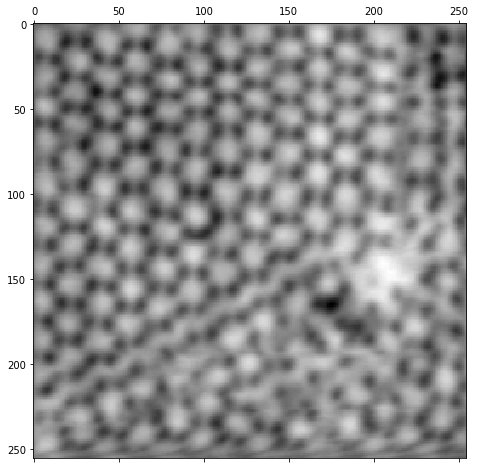

In [28]:
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(phase)
plt.show()

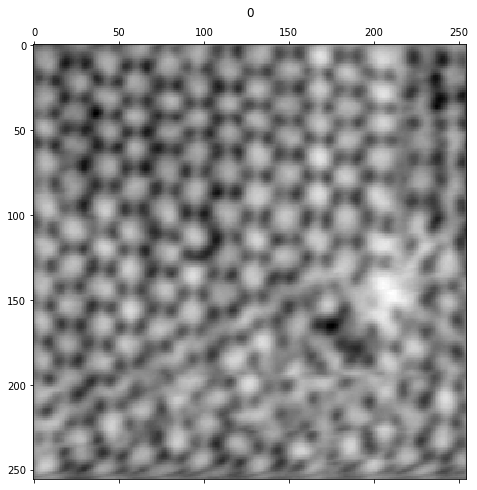

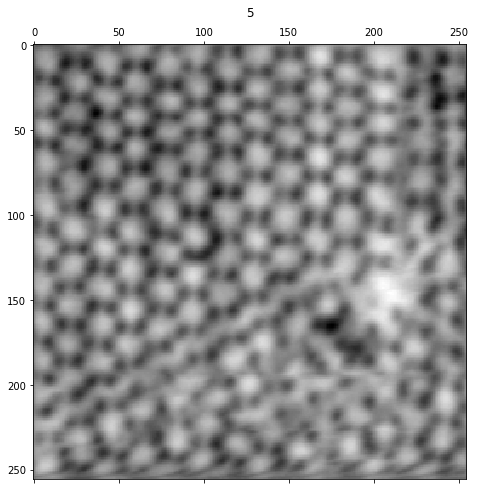

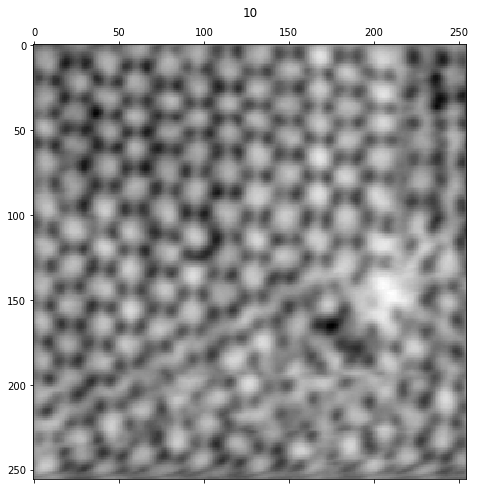

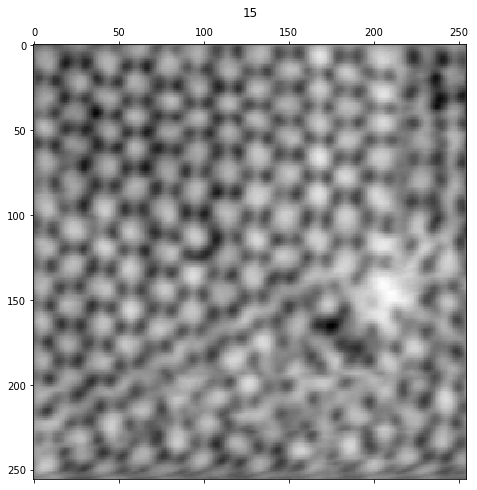

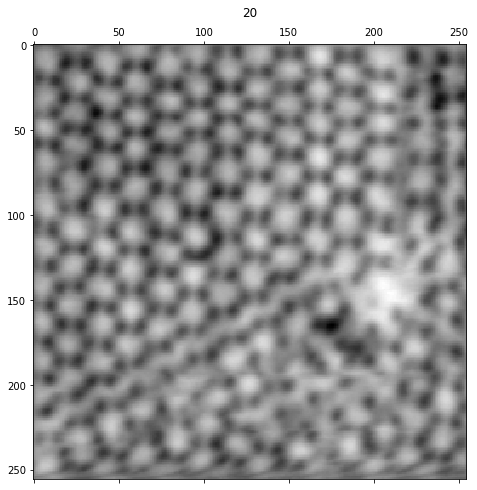

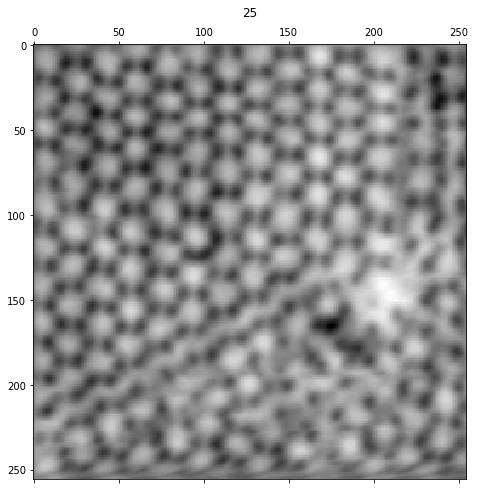

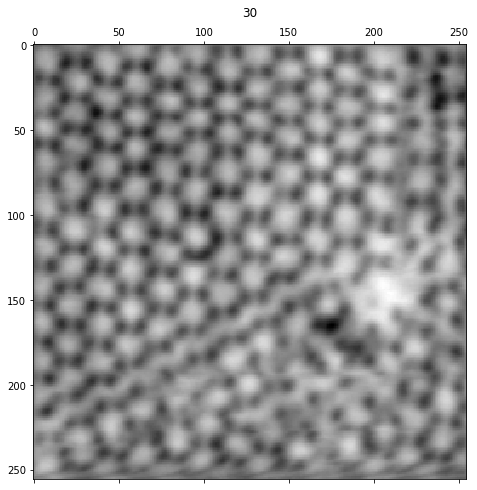

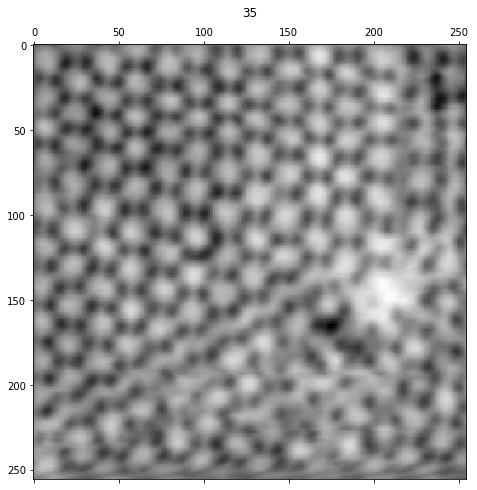

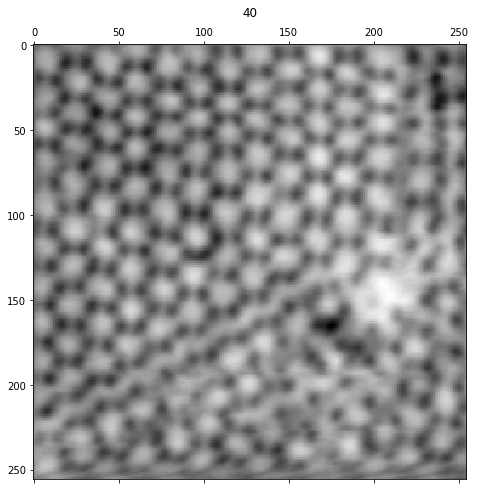

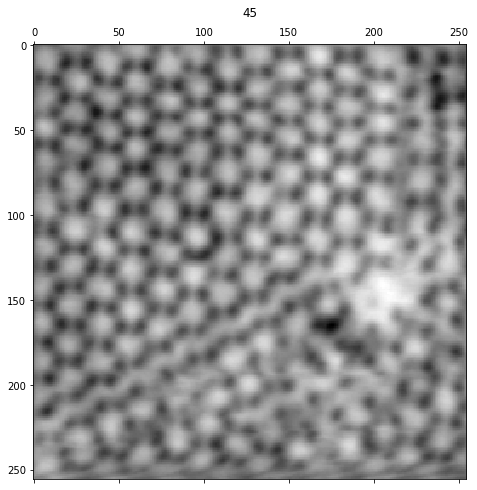

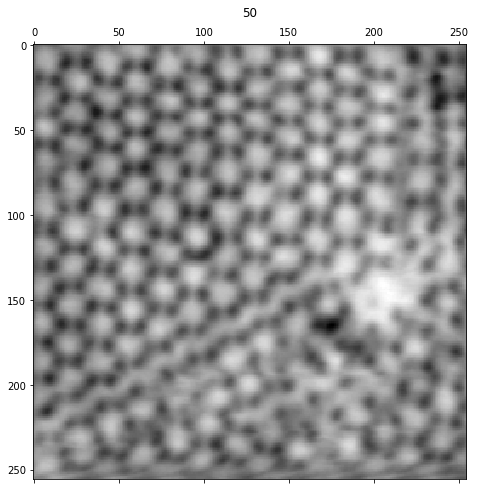

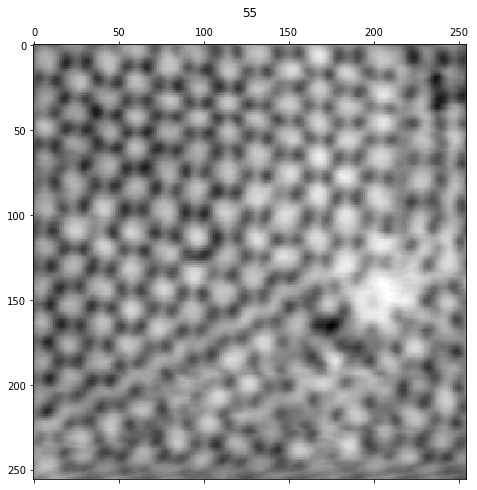

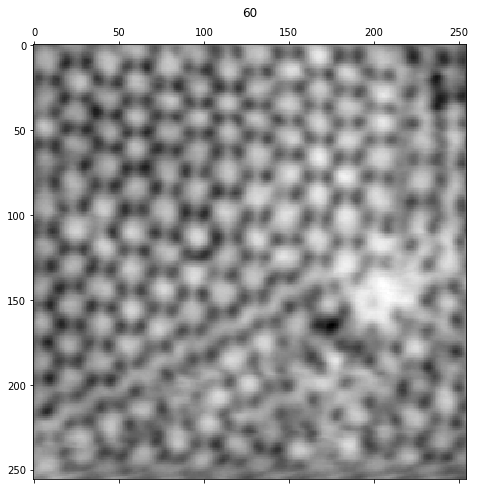

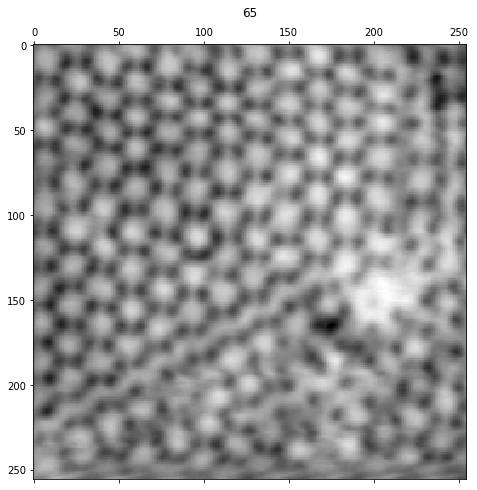

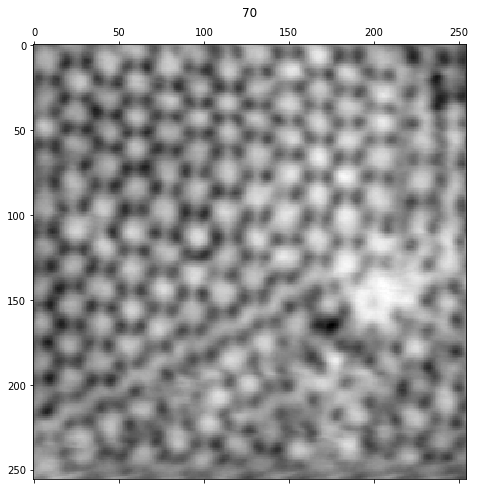

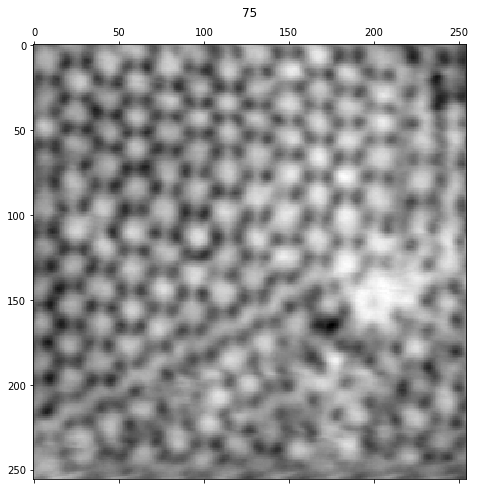

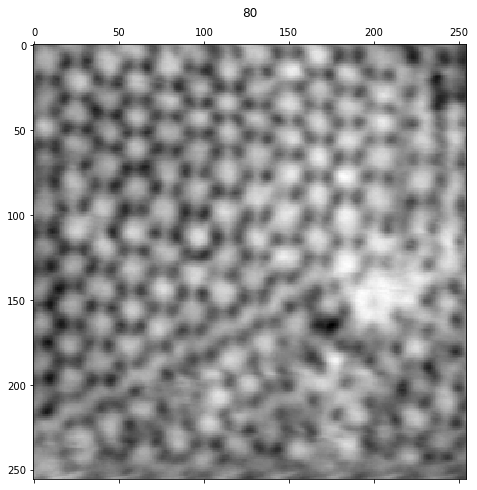

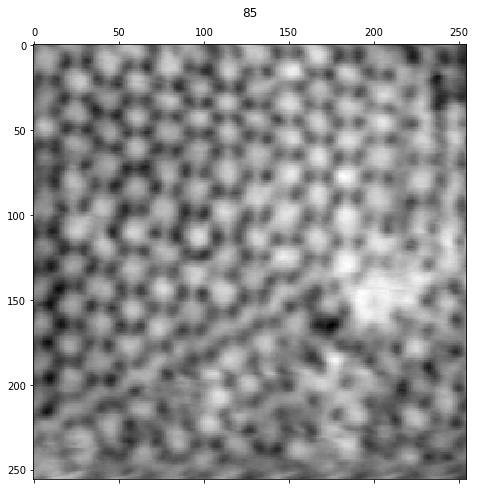

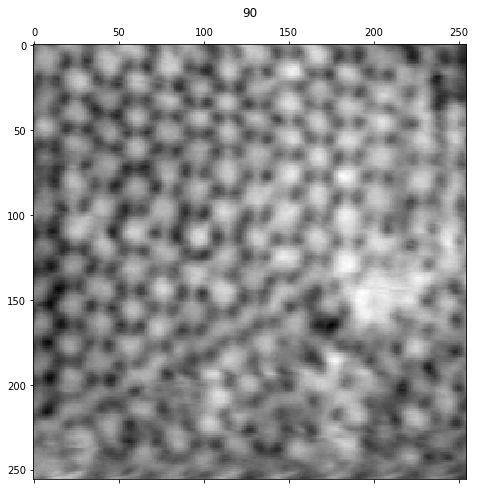

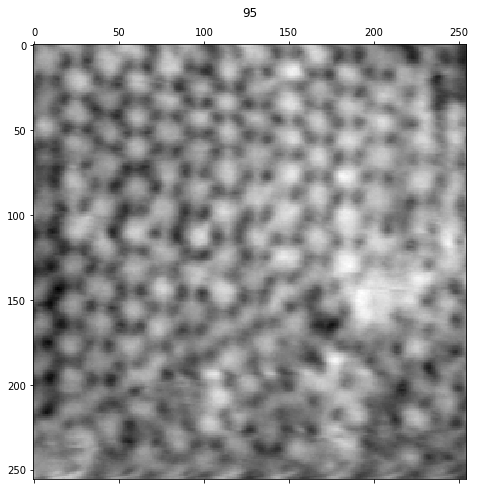

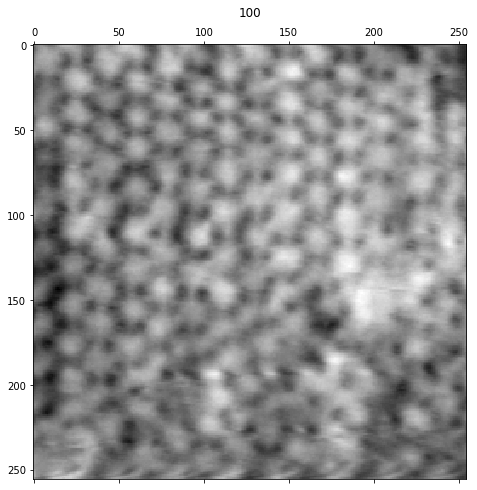

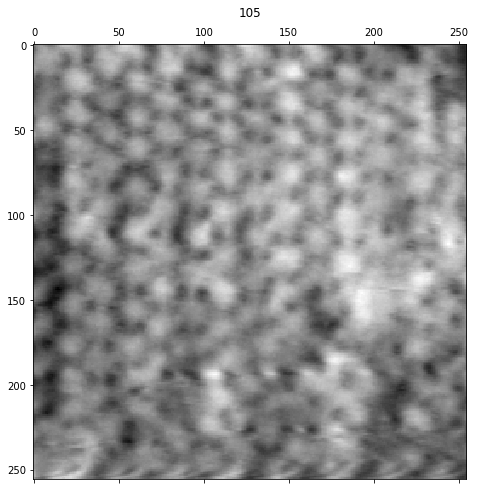

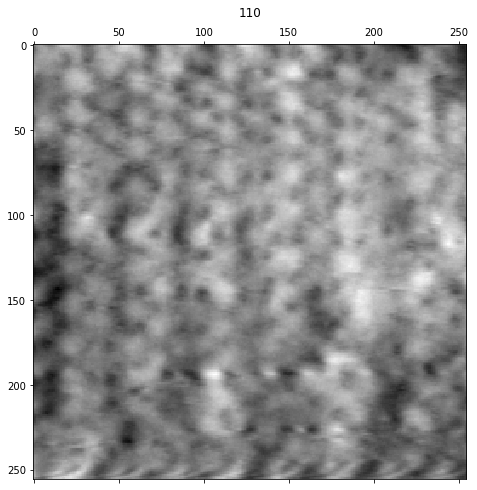

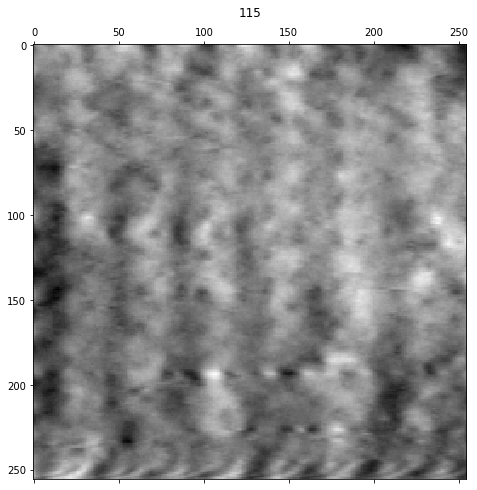

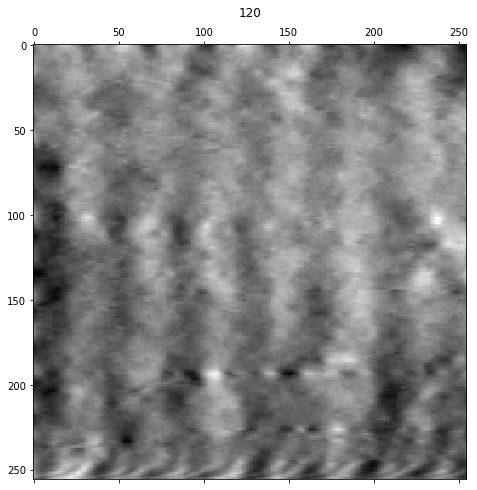

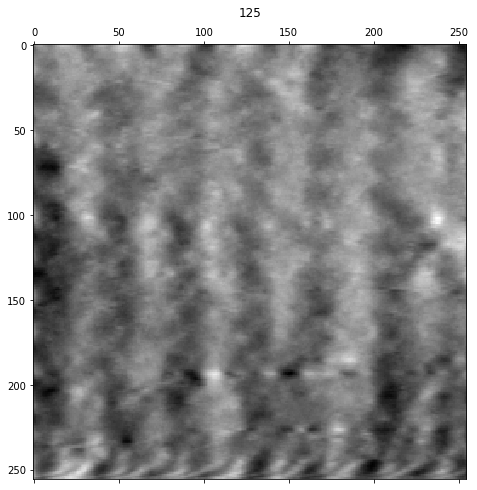

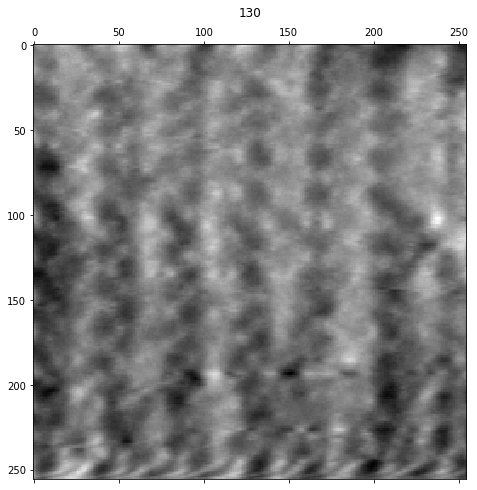

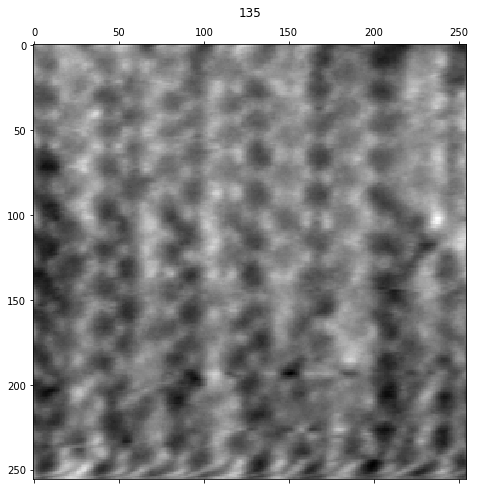

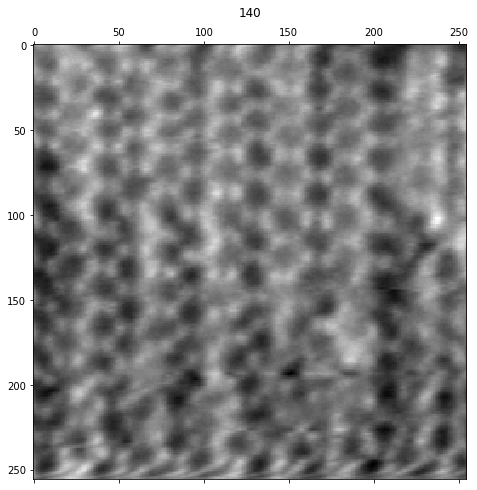

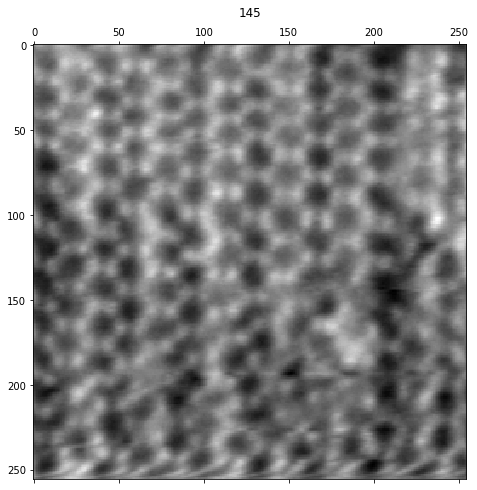

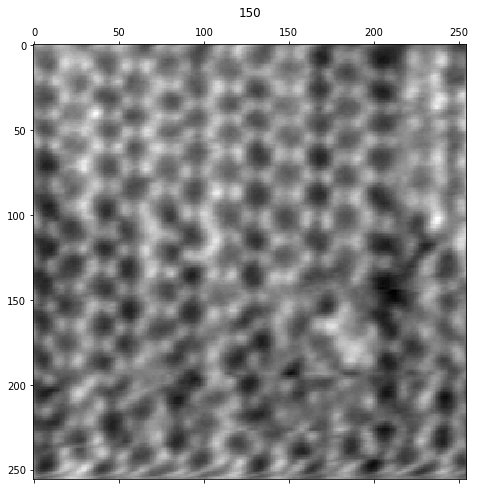

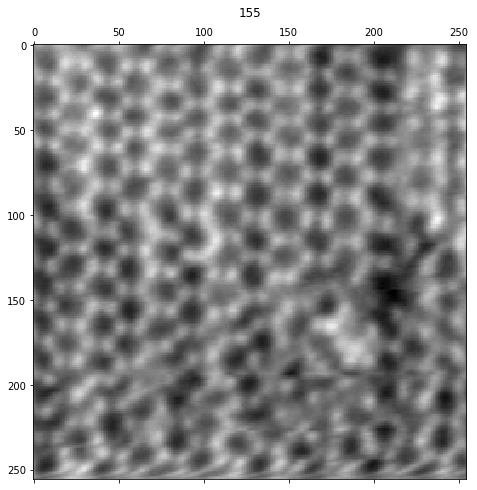

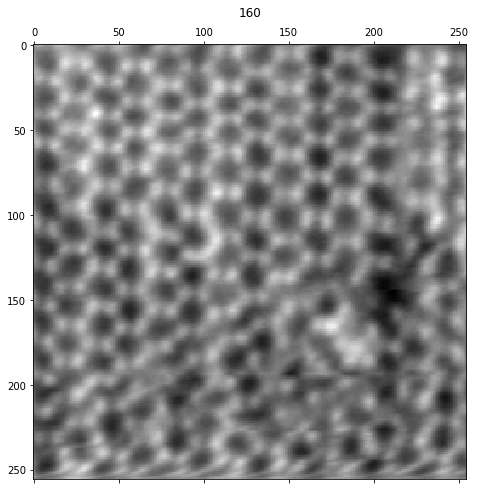

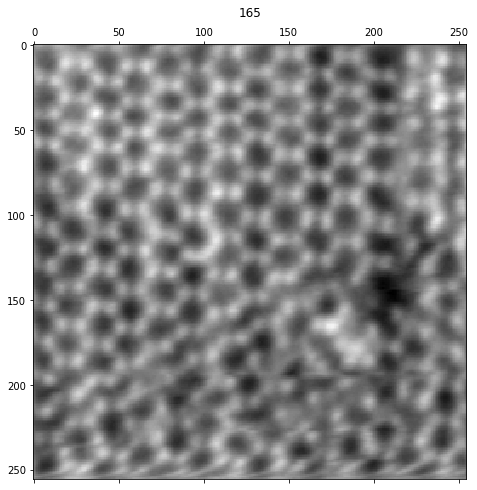

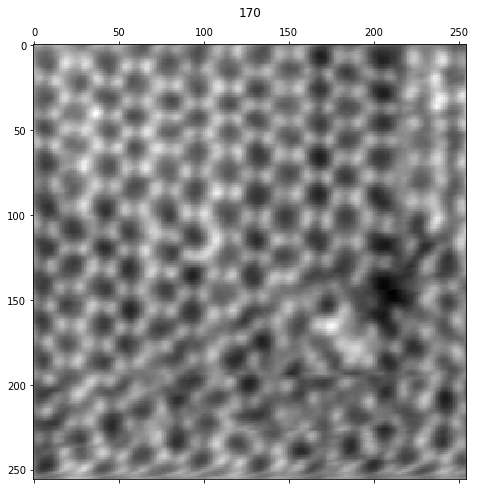

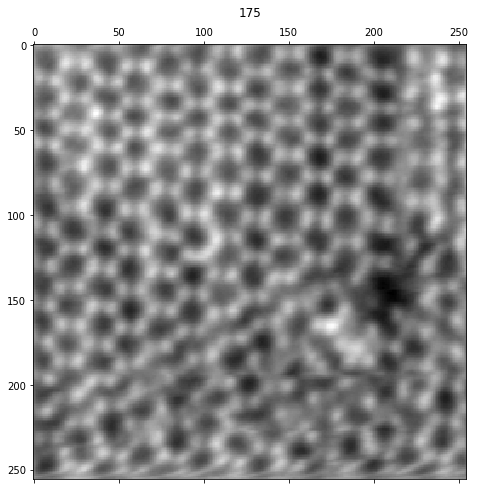

In [29]:
angles = np.arange(180)[::5]
n_iter = 1
pad = 1

for angle in angles:

    # Rotate CoMs
    CoMx_rot,CoMy_rot = py4DSTEM.process.dpc.rotate_point((0,0), [CoMx,CoMy], np.radians(angle))

    # Pad arrays
    CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    mask_pad = np.pad(np.ones_like(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')==1
    R_Nx_pad,R_Ny_pad = mask_pad.shape

    # Operators for solving the differential equation in Fourier space
    # See, e.g., Close et al, Ultramic 159 (2015) 124-137 or Ishizuka, Microscopy (2017) 397-405
    kx,ky = py4DSTEM.process.utils.make_Fourier_coords2D(R_Nx_pad,R_Ny_pad,pixelSize=1)
    kr2 = (kx**2+ky**2)
    denominator = 1j*kr2
    mask_divbyzero = np.abs(denominator) > 1e-16

    # Reconstruction
    phase = np.zeros((R_Nx_pad,R_Ny_pad))
    qphase = np.zeros((R_Nx_pad,R_Ny_pad),dtype=complex)
    for i in range(n_iter):
        # Take Fourier transform of CoM components
        fftIx = np.fft.fft2(np.asarray(CoMx_pad,dtype=complex))
        fftIy = np.fft.fft2(np.asarray(CoMy_pad,dtype=complex))

        # Again, see Close et al or Ishizuka et al
        numerator = (kx*fftIx + ky*fftIy)

        # Calculate phase solution
        qphase[mask_divbyzero] = numerator[mask_divbyzero] / denominator[mask_divbyzero]

        # Return real part of inverse Fourier transform of phase
        phase += np.real(np.fft.fft2(qphase))

        # Iteratively: find difference between CoM predicted from current solution of potential and measured CoM
        CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
        CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
        CoMx_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)
        CoMy_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)

    phase = phase[dc.R_Nx*pad:dc.R_Nx*(pad+1),dc.R_Ny*pad:dc.R_Ny*(pad+1)]
    
    fig,ax = plt.subplots(figsize=(8,8))
    ax.matshow(phase)
    ax.set_title("{}".format(angle))
    plt.show()

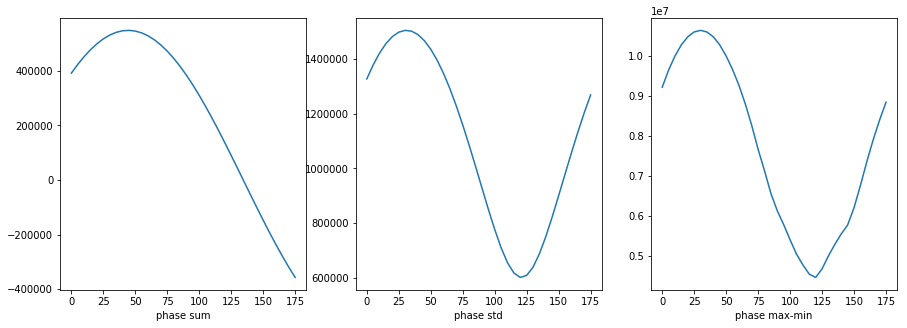

In [30]:
angles = np.arange(180)[::5]
n_iter = 1
pad = 1

scores = np.zeros((len(angles),3))
for j in range(len(angles)):
    angle = angles[j]
    
    # Rotate CoMs
    CoMx_rot,CoMy_rot = py4DSTEM.process.dpc.rotate_point((0,0), [CoMx,CoMy], np.radians(angle))

    # Pad arrays
    CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    mask_pad = np.pad(np.ones_like(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')==1
    R_Nx_pad,R_Ny_pad = mask_pad.shape

    # Operators for solving the differential equation in Fourier space
    # See, e.g., Close et al, Ultramic 159 (2015) 124-137 or Ishizuka, Microscopy (2017) 397-405
    kx,ky = py4DSTEM.process.utils.make_Fourier_coords2D(R_Nx_pad,R_Ny_pad,pixelSize=1)
    kr2 = (kx**2+ky**2)
    denominator = 1j*kr2
    mask_divbyzero = np.abs(denominator) > 1e-16

    # Reconstruction
    phase = np.zeros((R_Nx_pad,R_Ny_pad))
    qphase = np.zeros((R_Nx_pad,R_Ny_pad),dtype=complex)
    for i in range(n_iter):
        # Take Fourier transform of CoM components
        fftIx = np.fft.fft2(np.asarray(CoMx_pad,dtype=complex))
        fftIy = np.fft.fft2(np.asarray(CoMy_pad,dtype=complex))

        # Again, see Close et al or Ishizuka et al
        numerator = (kx*fftIx + ky*fftIy)

        # Calculate phase solution
        qphase[mask_divbyzero] = numerator[mask_divbyzero] / denominator[mask_divbyzero]

        # Return real part of inverse Fourier transform of phase
        phase += np.real(np.fft.fft2(qphase))

        # Iteratively: find difference between CoM predicted from current solution of potential and measured CoM
        CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
        CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
        CoMx_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)
        CoMy_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)

    phase = phase[dc.R_Nx*pad:dc.R_Nx*(pad+1),dc.R_Ny*pad:dc.R_Ny*(pad+1)]
    
    scores[j,0] = np.average(phase)
    scores[j,1] = np.std(phase)
    scores[j,2] = np.max(phase)-np.min(phase)
    
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(angles,scores[:,0])
ax2.plot(angles,scores[:,1])
ax3.plot(angles,scores[:,2])
ax1.set_xlabel('phase sum')
ax2.set_xlabel('phase std')
ax3.set_xlabel('phase max-min')
plt.show()

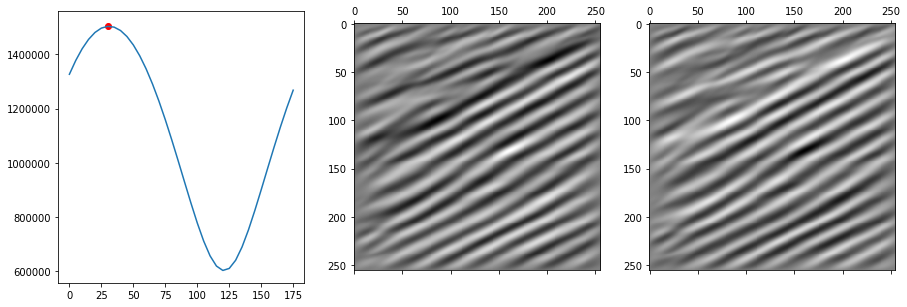

In [32]:
index = np.argmax(scores[:,1])

n_iter = 10
pad = 1

angle1 = angles[index]
angle2 = angle1 + 180
choices = [angle1,angle2]

phases = np.zeros((dc.R_Nx,dc.R_Ny,2))

for j in range(len(choices)):
    angle = choices[j]

    # Rotate CoMs
    CoMx_rot,CoMy_rot = py4DSTEM.process.dpc.rotate_point((0,0), [CoMx,CoMy], np.radians(angle))

    # Pad arrays
    CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
    mask_pad = np.pad(np.ones_like(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')==1
    R_Nx_pad,R_Ny_pad = mask_pad.shape

    # Operators for solving the differential equation in Fourier space
    # See, e.g., Close et al, Ultramic 159 (2015) 124-137 or Ishizuka, Microscopy (2017) 397-405
    kx,ky = py4DSTEM.process.utils.make_Fourier_coords2D(R_Nx_pad,R_Ny_pad,pixelSize=1)
    kr2 = (kx**2+ky**2)
    denominator = 1j*kr2
    mask_divbyzero = np.abs(denominator) > 1e-16

    # Reconstruction
    phase = np.zeros((R_Nx_pad,R_Ny_pad))
    qphase = np.zeros((R_Nx_pad,R_Ny_pad),dtype=complex)
    for i in range(n_iter):
        # Take Fourier transform of CoM components
        fftIx = np.fft.fft2(np.asarray(CoMx_pad,dtype=complex))
        fftIy = np.fft.fft2(np.asarray(CoMy_pad,dtype=complex))

        # Again, see Close et al or Ishizuka et al
        numerator = (kx*fftIx + ky*fftIy)

        # Calculate phase solution
        qphase[mask_divbyzero] = numerator[mask_divbyzero] / denominator[mask_divbyzero]

        # Return real part of inverse Fourier transform of phase
        phase += np.real(np.fft.fft2(qphase))

        # Iteratively: find difference between CoM predicted from current solution of potential and measured CoM
        CoMx_pad = np.pad(np.copy(CoMx_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
        CoMy_pad = np.pad(np.copy(CoMy_rot),((pad*dc.R_Nx,pad*dc.R_Nx),(pad*dc.R_Nx,pad*dc.R_Ny)),mode='constant')
        CoMx_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)
        CoMy_pad[mask_pad] -= np.gradient(phase,axis=0)[mask_pad]/(2*np.pi)

    phase = phase[dc.R_Nx*pad:dc.R_Nx*(pad+1),dc.R_Ny*pad:dc.R_Ny*(pad+1)]
    phases[:,:,j] = phase
    
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(angles,scores[:,1])
ax1.scatter(angles[index],scores[index,1],color='r')
ax2.matshow(phases[:,:,0])
ax3.matshow(phases[:,:,1])
plt.show()